
# Hull–White Interest Rate Model & Swap Pricing: Detailed Explanation


---

## Overview

The code implements the Hull–White one-factor short rate model, widely used for pricing interest rate derivatives such as swaps and bonds. It uses both Monte Carlo simulation (via Euler discretization) and analytical expressions to price zero-coupon bonds (ZCBs) and interest rate swaps.  
 
- **Quant Finance Insight:**  
  The model is calibrated to fit the market’s initial yield curve by adjusting a drift term $\theta(t)$, and then simulates the evolution of the short rate using:
  
  $$ dr_t = \lambda \big(\theta(t)-r_t\big) dt + \eta\, dW_t $$
  
- **Nitish Sir’s Explanation (Hinglish):**  
  *Bhai, yeh code market ke curve se shuruat karke, Euler method se random interest rate paths generate karta hai aur phir swap ya bond ke prices analytical aur simulation dono tareekon se nikalta hai.*

---

## 1. Option Type Enumeration

```python
class OptionTypeSwap(enum.Enum):
    RECEIVER = 1.0
    PAYER = -1.0
```

- **Explanation:**  
  This enumeration defines the two swap positions:
  - **RECEIVER ($1.0$):** Receives fixed payments.
  - **PAYER ($-1.0$):** Pays fixed payments.
- **Theory:**  
  The sign (positive/negative) helps determine the direction of cash flows in swap pricing.

---

## 2. Generating Hull–White Paths: `GeneratePathsHWEuler`

```python
def GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T, P0T, lambd, eta):    
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    r0 = f0T(0.00001)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))      
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    R = np.zeros([NoOfPaths, NoOfSteps+1])
    R[:,0]=r0
    time = np.zeros([NoOfSteps+1])
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.sqrt(dt)*Z[:,i]
        R[:,i+1] = R[:,i] + lambd*(theta(time[i]) - R[:,i]) * dt + eta*(W[:,i+1]-W[:,i])
        time[i+1] = time[i] + dt
    paths = {"time":time,"R":R}
    return paths
```

### Explanation:
- **Finite Difference Approximation:**  
  The instantaneous forward rate is approximated by  
  $$ f_0(t) \approx -\frac{\ln\big(P_0T(t+dt)\big) - \ln\big(P_0T(t-dt)\big)}{2\,dt} $$
- **Initial Short Rate:**  
  Set as  
  $$ r_0 = f_0(0) $$
- **Drift Adjustment $\theta(t)$:**  
  Calculated using  
  $$ \theta(t) = \frac{1}{\lambda}\frac{f_0(t+dt)-f_0(t-dt)}{2\,dt} + f_0(t) + \frac{\eta^2}{2\lambda^2}\Big(1-e^{-2\lambda t}\Big) $$
- **Euler Discretization:**  
  The short rate evolution is given by:  
  $$ dr_t = \lambda\big(\theta(t)-r_t\big)dt + \eta\, dW_t $$
  
- **Hinglish Note:**  
  *Yeh function Euler method se random interest rate paths generate karta hai, market se forward rate aur drift $\theta(t)$ nikal ke.*

---

## 3. Computing $\theta(t)$: `HW_theta`

```python
def HW_theta(lambd, eta, P0T):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    return theta
```

### Explanation:
- **Purpose:**  
  Returns the drift function $\theta(t)$ used to calibrate the model to the initial yield curve.
- **Formula Recap:**  
  $$ \theta(t) = \frac{1}{\lambda}\frac{f_0(t+dt)-f_0(t-dt)}{2\,dt} + f_0(t) + \frac{\eta^2}{2\lambda^2}\Big(1-e^{-2\lambda t}\Big) $$

---

## 4. The $A$ Function: `HW_A`

```python
def HW_A(lambd, eta, P0T, T1, T2):
    tau = T2-T1
    zGrid = np.linspace(0.0,tau,250)
    B_r = lambda tau: 1.0/lambd * (np.exp(-lambd *tau)-1.0)
    theta = HW_theta(lambd,eta,P0T)    
    temp1 = lambd * integrate.trapz(theta(T2-zGrid)*B_r(zGrid),zGrid)
    temp2 = eta*eta/(4.0*np.power(lambd,3.0)) * (np.exp(-2.0*lambd*tau)*(4*np.exp(lambd*tau)-1.0) -3.0) + eta*eta*tau/(2.0*lambd*lambd)
    return temp1 + temp2
```

### Explanation:
- **Integration for $A(T_1,T_2)$:**  
  The function calculates:
  
  $$ A(T_1,T_2) = \lambda \int_0^{\tau} \theta(T_2-z) \, B(z)\, dz + \text{(volatility adjustment)} $$
  
  where $\tau = T_2-T_1$ and
  
  $$ B(z) = \frac{1}{\lambda}\left(e^{-\lambda z}-1\right) $$
- **Volatility Adjustment Term:**  
  $$ \text{temp2} = \frac{\eta^2}{4\lambda^3}\Big(e^{-2\lambda \tau}(4e^{\lambda \tau}-1)-3\Big) + \frac{\eta^2\tau}{2\lambda^2} $$

---

## 5. The $B$ Function: `HW_B`

```python
def HW_B(lambd, eta, T1, T2):
    return 1.0/lambd *(np.exp(-lambd*(T2-T1))-1.0)
```

### Explanation:
- **Theory:**  
  $$ B(T_1,T_2) = \frac{1}{\lambda}\left(e^{-\lambda(T_2-T_1)}-1\right) $$
- **Purpose:**  
  This function quantifies the sensitivity of the bond price to changes in the short rate.

---

## 6. Zero-Coupon Bond Pricing: `HW_ZCB`

```python
def HW_ZCB(lambd, eta, P0T, T1, T2, rT1):
    n = np.size(rT1) 
    if T1 < T2:
        B_r = HW_B(lambd, eta, T1, T2)
        A_r = HW_A(lambd, eta, P0T, T1, T2)
        return np.exp(A_r + B_r * rT1)
    else:
        return np.ones([n])
```

### Explanation:
- **Bond Price Formula:**  
  The analytical zero-coupon bond price is given by:
  
  $$ P(T_1,T_2) = \exp\Big(A(T_1,T_2) + B(T_1,T_2)\, r_{T_1}\Big) $$
- **Maturity Condition:**  
  If $T_1 \ge T_2$, the bond is matured, hence $P=1$.

---

## 7. Initial Short Rate Calculation: `HW_r_0`

```python
def HW_r_0(P0T, lambd, eta):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    r0 = f0T(0.00001)
    return r0
```

### Explanation:
- **Purpose:**  
  Uses finite differences to approximate the instantaneous forward rate and set the initial short rate:
  
  $$ r_0 \approx f_0(0) $$

---

## 8. Swap Pricing Using Market Discount Factors: `SwapPrice`

```python
def SwapPrice(CP, notional, K, t, Ti, Tm, n, P0T):
    if n == 1:
        ti_grid = np.array([Ti,Tm])
    else:
        ti_grid = np.linspace(Ti,Tm,n)
    tau = ti_grid[1]- ti_grid[0]
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0:
        Ti = prevTi[-1]
    ti_grid = ti_grid[np.where(ti_grid>t)]          
    temp = 0.0
    for (idx,ti) in enumerate(ti_grid):
        if ti>Ti:
            temp = temp + tau * P0T(ti)
    if CP==OptionTypeSwap.PAYER:
        swap = (P0T(Ti) - P0T(Tm)) - K * temp
    elif CP==OptionTypeSwap.RECEIVER:
        swap = K * temp- (P0T(Ti) - P0T(Tm))
    return swap*notional
```

### Explanation:
- **Swap Price Formula:**  
  For a payer swap, the swap value is computed as:
  
  $$ \text{Swap} = \Big(P_0(T_i)-P_0(T_m)\Big) - K \sum \tau\, P_0(t_i) $$
  
  and similarly for a receiver swap.
- **Purpose:**  
  It calculates the net present value (NPV) of the swap’s cash flows using the market ZCB curve.

- **Hinglish Note:**  
  *Fixed leg ke cash flows ko discount karke, swap ki value nikalte hain.*

---

## 9. Swap Pricing Using Hull–White Simulation: `HW_SwapPrice`

```python
def HW_SwapPrice(CP, notional, K, t, Ti, Tm, n, r_t, P0T, lambd, eta):
    if n == 1:
        ti_grid = np.array([Ti,Tm])
    else:
        ti_grid = np.linspace(Ti,Tm,n)
    tau = ti_grid[1]- ti_grid[0]
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0:
        Ti = prevTi[-1]
    ti_grid = ti_grid[np.where(ti_grid>t)]          
    temp = np.zeros(np.size(r_t))
    P_t_TiLambda = lambda Ti : HW_ZCB(lambd, eta, P0T, t, Ti, r_t)
    for (idx,ti) in enumerate(ti_grid):
        if ti>Ti:
            temp = temp + tau * P_t_TiLambda(ti)
    P_t_Ti = P_t_TiLambda(Ti)
    P_t_Tm = P_t_TiLambda(Tm)
    if CP==OptionTypeSwap.PAYER:
        swap = (P_t_Ti - P_t_Tm) - K * temp
    elif CP==OptionTypeSwap.RECEIVER:
        swap = K * temp- (P_t_Ti - P_t_Tm)
    return swap*notional
```

### Explanation:
- **Theory:**  
  This function uses simulated short rate paths to compute discount factors:
  
  $$ P_t(T_i) = \exp\Big(A(t,T_i)+B(t,T_i)\, r_t\Big) $$
  
- **Process:**  
  Similar to the market-based swap pricing but using the simulated rates.
- **Hinglish Note:**  
  *Monte Carlo simulation se calculated rates se swap price nikalte hain.*

---

## 10. Main Calculation: `mainCalculation`

```python
def mainCalculation():
    NoOfPaths = 2000
    NoOfSteps = 1000
    CP = OptionTypeSwap.PAYER
    lambd     = 0.5
    eta       = 0.03
    notional  = 10000.0 
    ti = []  # Market time points for ZCB curve (to be provided)
    pi = []  # Corresponding market ZCB prices (to be provided)
    interpolator =  interpolate.splrep(ti, pi, s=0.0001)
    P0T = lambda T: interpolate.splev(T, interpolator, der=0)
    r0 = HW_r_0(P0T,lambd,eta)
    N = 25
    T_end = 50
    Tgrid= np.linspace(0,T_end,N)
    Exact = np.zeros([N,1])
    Proxy = np.zeros ([N,1])
    for i,Ti in enumerate(Tgrid):
        Proxy[i] = HW_ZCB(lambd,eta,P0T,0.0,Ti,r0)
        Exact[i] = P0T(Ti)
    plt.figure(1)
    plt.grid()
    plt.plot(Tgrid,Exact,'-k')
    plt.plot(Tgrid,Proxy,'--r')
    plt.legend(["Analytical ZCB","Monte Carlo ZCB"])
    plt.title('P(0,T): Monte Carlo vs. Analytical')
    
    # Swap Pricing Parameters
    K = np.linspace(-0.1,0.1,25)
    Ti = 1.0
    Tm = 10.0
    n = 10
    paths = GeneratePathsHWEuler(NoOfPaths, NoOfSteps, Tm + 1.0, P0T, lambd, eta)
    r = paths["R"]
    timeGrid = paths["time"]
    dt = timeGrid[1]-timeGrid[0]
    M_t = np.zeros([NoOfPaths,NoOfSteps])
    for i in range(0,NoOfPaths):
        M_t[i,:] = np.exp(np.cumsum(r[i,0:-1])*dt)
    VSwapHW = np.zeros(len(K))
    VSwap = np.zeros(len(K))
    t0 = 0
    for (idx,Ki) in enumerate(K):
        VHW = HW_SwapPrice(CP, notional, Ki, t0, Ti, Tm, n, r0, P0T, lambd, eta)
        V = SwapPrice(CP, notional, Ki, t0, Ti, Tm, n, P0T)
        VSwap[idx] = V
        VSwapHW[idx] = VHW[0]
    plt.figure(2)
    plt.plot(K,VSwap)
    plt.plot(K,VSwapHW,'--r')
    plt.grid()
    plt.xlabel('Strike (K)')
    plt.ylabel('Swap Value')
    plt.title('Swap Pricing')
    
    print('Swap price for K = 0 is {0}'.format(SwapPrice(CP, notional, 0.0, t0, Ti, Tm, n, P0T)))
    func = lambda k: SwapPrice(CP, notional, k, t0, Ti, Tm, n, P0T)
    K_par = newton(func, 0.0)
    print('Swap price for K_par = {0} is {1}'.format(K_par, SwapPrice(CP, notional, K_par, t0, Ti, Tm, n, P0T)))
    
mainCalculation()
```

### Explanation:
- **Integration of Components:**  
  This function brings together:
  - **Market Curve Calibration:**  
    Uses B-spline interpolation to form the market zero-coupon bond curve $P(0,T)$.
  - **Initial Rate & Path Simulation:**  
    Obtains $r_0$ and generates simulated interest rate paths.
  - **Bond & Swap Pricing:**  
    Compares analytical ZCB prices with simulated ones and prices swaps using both market discount factors and simulated rates.
  - **Par Swap Rate:**  
    Determines the swap rate for which the swap value is zero.
  
- **Interview Tip:**  
  *Discuss how calibration (via $\theta(t)$) and simulation versus analytical pricing methods are applied in real-world quant models.*

---

## Final Remarks

- **Quant Finance Perspective:**  
  This implementation illustrates how the Hull–White model is used for pricing fixed-income derivatives, a common topic in quant interviews.

- **Hinglish Summary:**  
  *Yeh notebook step-by-step Hull–White model ke simulation aur swap pricing ko explain karta hai, jo interview preparation aur practical quant finance applications me bahut useful hai.*

---
```

Swap price for K = 0 is 2835.619745580199
Swap price for K_par = 0.022561281832882155 is 0.0


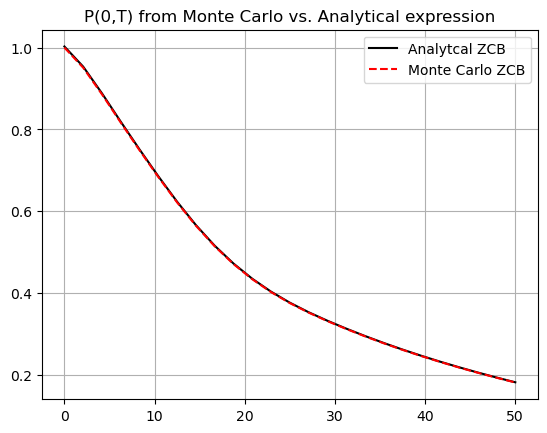

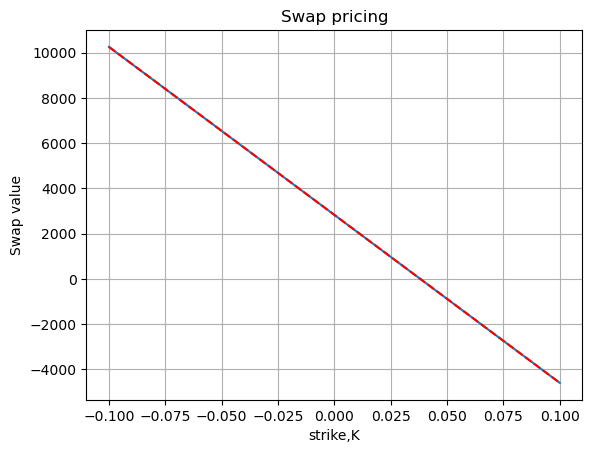

In [1]:
import numpy as np
import enum
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import interpolate
from scipy.optimize import newton

class OptionTypeSwap(enum.Enum):
    RECEIVER=1.0
    PAYER=-1.0
    
def GeneratePathsHWEuler(NoOfPaths,NoOfSteps,T,P0T, lambd, eta):
    dt=0.0001
    f0T=lambda t:-(np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    r0=f0T(0.00001)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))      

    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    R = np.zeros([NoOfPaths, NoOfSteps+1])
    R[:,0]=r0
    time = np.zeros([NoOfSteps+1])
    dt = T / float(NoOfSteps)
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        R[:,i+1] = R[:,i] + lambd*(theta(time[i]) - R[:,i]) * dt + eta* (W[:,i+1]-W[:,i])
        time[i+1] = time[i] +dt
    paths = {"time":time,"R":R}
    return paths
        
def HW_theta(lambd,eta,P0T):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    
    return theta
def HW_A(lambd,eta,P0T,T1,T2):
    tau = T2-T1
    zGrid = np.linspace(0.0,tau,250)
    B_r = lambda tau: 1.0/lambd * (np.exp(-lambd *tau)-1.0)
    theta = HW_theta(lambd,eta,P0T)    
    temp1 = lambd * integrate.trapz(theta(T2-zGrid)*B_r(zGrid),zGrid)
    
    temp2 = eta*eta/(4.0*np.power(lambd,3.0)) * (np.exp(-2.0*lambd*tau)*(4*np.exp(lambd*tau)-1.0) -3.0) + eta*eta*tau/(2.0*lambd*lambd)
    
    return temp1 + temp2

def HW_B(lambd,eta,T1,T2):
    return 1.0/lambd *(np.exp(-lambd*(T2-T1))-1.0)
    
def HW_ZCB(lambd,eta,P0T,T1,T2,rT1):
    n = np.size(rT1) 
        
    if T1<T2:
        B_r = HW_B(lambd,eta,T1,T2)
        A_r = HW_A(lambd,eta,P0T,T1,T2)
        return np.exp(A_r + B_r *rT1)
    else:
        return np.ones([n])

def HW_r_0(P0T,lambd,eta):
    # time-step needed for differentiation
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    return r0

def SwapPrice(CP,notional,K,t,Ti,Tm,n,P0T):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t
    if n==1:
        ti_grid=np.array([Ti,Tm])
    else:
        ti_grid=np.array([Ti,Tm,n])
    tau=ti_grid[1]-ti_grid[0]
    
    # overwriting Ti if t>Ti
    prevTi=ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi)>0:
        Ti=prevTi[-1]
        
    #now we can handel case where payment is done
    ti_grid=ti_grid[np.where(ti_grid>t)]
    temp=0.0
    for(idx,ti) in enumerate(ti_grid):
        if ti>Ti:
            temp=temp+tau*P0T(ti)
    if CP==OptionTypeSwap.PAYER:
        swap=(P0T(Ti)-P0T(Tm))-K*temp
    elif CP==OptionTypeSwap.RECEIVER:
        swap=K*temp-(P0T(Ti)-P0T(Tm))
    return swap*notional

def HW_SwapPrice(CP,notional,K,t,Ti,Tm,n,r_t,P0T,lambd,eta):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t
    if n == 1:
        ti_grid =np.array([Ti,Tm])
    else:
        ti_grid = np.linspace(Ti,Tm,n)
    tau = ti_grid[1]- ti_grid[0]
    
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0: #prevTi != []:
        Ti = prevTi[-1]
    
    # Now we need to handle the case when some payments are already done
    ti_grid = ti_grid[np.where(ti_grid>t)]          

    temp=np.zeros(np.size(r_t));
    P_t_TiLambda=lambda Ti: HW_ZCB(lambd,eta,P0T,t,Ti,r_t)
    
    for (idx,ti) in enumerate(ti_grid):
        if ti>Ti:
            temp = temp + tau * P_t_TiLambda(ti)
            
    P_t_Ti = P_t_TiLambda(Ti)
    P_t_Tm = P_t_TiLambda(Tm)
    if CP==OptionTypeSwap.PAYER:
        swap = (P_t_Ti - P_t_Tm) - K * temp
    elif CP==OptionTypeSwap.RECEIVER:
        swap = K * temp- (P_t_Ti - P_t_Tm)
    
    return swap*notional

def mainCalculation():
    NoOfPaths = 2000
    NoOfSteps = 1000
    CP = OptionTypeSwap.PAYER
    lambd     = 0.5
    eta       = 0.03
    notional  = 10000.0 
    ti = [0.0,0.00273972600000000,0.0876712330000000,0.172602740000000,0.257534247000000,0.342465753000000,0.427397260000000,0.512328767000000,0.597260274000000,0.682191781000000,0.767123288000000,0.852054795000000,0.936986301000000,1.02191780800000,1.10684931500000,1.19178082200000,1.27671232900000,1.36164383600000,1.44657534200000,1.53150684900000,1.61643835600000,1.70136986300000,1.78630137000000,1.87123287700000,1.95616438400000,2.04109589000000,2.12602739700000,2.21095890400000,2.29589041100000,2.38082191800000,2.46575342500000,2.55068493200000,2.63561643800000,2.72054794500000,2.80547945200000,2.89041095900000,2.97534246600000,3.06027397300000,3.14520547900000,3.23013698600000,3.31506849300000,3.40000000000000,3.48493150700000,3.56986301400000,3.65479452100000,3.73972602700000,3.82465753400000,3.90958904100000,3.99452054800000,4.07945205500000,4.16438356200000,4.24931506800000,4.33424657500000,4.41917808200000,4.50410958900000,4.58904109600000,4.67397260300000,4.75890411000000,4.84383561600000,4.92876712300000,5.01369863000000,5.09863013700000,5.18356164400000,5.26849315100000,5.35342465800000,5.43835616400000,5.52328767100000,5.60821917800000,5.69315068500000,5.77808219200000,5.86301369900000,5.94794520500000,6.03287671200000,6.11780821900000,6.20273972600000,6.28767123300000,6.37260274000000,6.45753424700000,6.54246575300000,6.62739726000000,6.71232876700000,6.79726027400000,6.88219178100000,6.96712328800000,7.05205479500000,7.13698630100000,7.22191780800000,7.30684931500000,7.39178082200000,7.47671232900000,7.56164383600000,7.64657534200000,7.73150684900000,7.81643835600000,7.90136986300000,7.98630137000000,8.07123287700000,8.15616438400000,8.24109589000000,8.32602739700000,8.41095890400000,8.49589041100000,8.58082191800000,8.66575342500000,8.75068493200000,8.83561643800000,8.92054794500000,9.00547945200000,9.09041095900000,9.17534246600000,9.26027397300000,9.34520547900000,9.43013698600000,9.51506849300000,9.60000000000000,9.68493150700000,9.76986301400000,9.85479452100000,9.93972602700000,10.0246575300000,10.1095890400000,10.1945205500000,10.2794520500000,10.3643835600000,10.4493150700000,10.5342465800000,10.6191780800000,10.7041095900000,10.7890411000000,10.8739726000000,10.9589041100000,11.0438356200000,11.1287671200000,11.2136986300000,11.2986301400000,11.3835616400000,11.4684931500000,11.5534246600000,11.6383561600000,11.7232876700000,11.8082191800000,11.8931506800000,11.9780821900000,12.0630137000000,12.1479452100000,12.2328767100000,12.3178082200000,12.4027397300000,12.4876712300000,12.5726027400000,12.6575342500000,12.7424657500000,12.8273972600000,12.9123287700000,12.9972602700000,13.0821917800000,13.1671232900000,13.2520547900000,13.3369863000000,13.4219178100000,13.5068493200000,13.5917808200000,13.6767123300000,13.7616438400000,13.8465753400000,13.9315068500000,14.0164383600000,14.1013698600000,14.1863013700000,14.2712328800000,14.3561643800000,14.4410958900000,14.5260274000000,14.6109589000000,14.6958904100000,14.7808219200000,14.8657534200000,14.9506849300000,15.0356164400000,15.1205479500000,15.2054794500000,15.2904109600000,15.3753424700000,15.4602739700000,15.5452054800000,15.6301369900000,15.7150684900000,15.8000000000000,15.8849315100000,15.9698630100000,16.0547945200000,16.1397260300000,16.2246575300000,16.3095890400000,16.3945205500000,16.4794520500000,16.5643835600000,16.6493150700000,16.7342465800000,16.8191780800000,16.9041095900000,16.9890411000000,17.0739726000000,17.1589041100000,17.2438356200000,17.3287671200000,17.4136986300000,17.4986301400000,17.5835616400000,17.6684931500000,17.7534246600000,17.8383561600000,17.9232876700000,18.0082191800000,18.0931506800000,18.1780821900000,18.2630137000000,18.3479452100000,18.4328767100000,18.5178082200000,18.6027397300000,18.6876712300000,18.7726027400000,18.8575342500000,18.9424657500000,19.0273972600000,19.1123287700000,19.1972602700000,19.2821917800000,19.3671232900000,19.4520547900000,19.5369863000000,19.6219178100000,19.7068493200000,19.7917808200000,19.8767123300000,19.9616438400000,20.0465753400000,20.1315068500000,20.2164383600000,20.3013698600000,20.3863013700000,20.4712328800000,20.5561643800000,20.6410958900000,20.7260274000000,20.8109589000000,20.8958904100000,20.9808219200000,21.0657534200000,21.1506849300000,21.2356164400000,21.3205479500000,21.4054794500000,21.4904109600000,21.5753424700000,21.6602739700000,21.7452054800000,21.8301369900000,21.9150684900000,22,22.0849315100000,22.1698630100000,22.2547945200000,22.3397260300000,22.4246575300000,22.5095890400000,22.5945205500000,22.6794520500000,22.7643835600000,22.8493150700000,22.9342465800000,23.0191780800000,23.1041095900000,23.1890411000000,23.2739726000000,23.3589041100000,23.4438356200000,23.5287671200000,23.6136986300000,23.6986301400000,23.7835616400000,23.8684931500000,23.9534246600000,24.0383561600000,24.1232876700000,24.2082191800000,24.2931506800000,24.3780821900000,24.4630137000000,24.5479452100000,24.6328767100000,24.7178082200000,24.8027397300000,24.8876712300000,24.9726027400000,25.0575342500000,25.1424657500000,25.2273972600000,25.3123287700000,25.3972602700000,25.4821917800000,25.5671232900000,25.6520547900000,25.7369863000000,25.8219178100000,25.9068493200000,25.9917808200000,26.0767123300000,26.1616438400000,26.2465753400000,26.3315068500000,26.4164383600000,26.5013698600000,26.5863013700000,26.6712328800000,26.7561643800000,26.8410958900000,26.9260274000000,27.0109589000000,27.0958904100000,27.1808219200000,27.2657534200000,27.3506849300000,27.4356164400000,27.5205479500000,27.6054794500000,27.6904109600000,27.7753424700000,27.8602739700000,27.9452054800000,28.0301369900000,28.1150684900000,28.2000000000000,28.2849315100000,28.3698630100000,28.4547945200000,28.5397260300000,28.6246575300000,28.7095890400000,28.7945205500000,28.8794520500000,28.9643835600000,29.0493150700000,29.1342465800000,29.2191780800000,29.3041095900000,29.3890411000000,29.4739726000000,29.5589041100000,29.6438356200000,29.7287671200000,29.8136986300000,29.8986301400000,29.9835616400000,30.0684931500000,30.1534246600000,30.2383561600000,30.3232876700000,30.4082191800000,30.4931506800000,30.5780821900000,30.6630137000000,30.7479452100000,30.8328767100000,30.9178082200000,31.0027397300000,31.0876712300000,31.1726027400000,31.2575342500000,31.3424657500000,31.4273972600000,31.5123287700000,31.5972602700000,31.6821917800000,31.7671232900000,31.8520547900000,31.9369863000000,32.0219178100000,32.1068493200000,32.1917808200000,32.2767123300000,32.3616438400000,32.4465753400000,32.5315068500000,32.6164383600000,32.7013698600000,32.7863013700000,32.8712328800000,32.9561643800000,33.0410958900000,33.1260274000000,33.2109589000000,33.2958904100000,33.3808219200000,33.4657534200000,33.5506849300000,33.6356164400000,33.7205479500000,33.8054794500000,33.8904109600000,33.9753424700000,34.0602739700000,34.1452054800000,34.2301369900000,34.3150684900000,34.4000000000000,34.4849315100000,34.5698630100000,34.6547945200000,34.7397260300000,34.8246575300000,34.9095890400000,34.9945205500000,35.0794520500000,35.1643835600000,35.2493150700000,35.3342465800000,35.4191780800000,35.5041095900000,35.5890411000000,35.6739726000000,35.7589041100000,35.8438356200000,35.9287671200000,36.0136986300000,36.0986301400000,36.1835616400000,36.2684931500000,36.3534246600000,36.4383561600000,36.5232876700000,36.6082191800000,36.6931506800000,36.7780821900000,36.8630137000000,36.9479452100000,37.0328767100000,37.1178082200000,37.2027397300000,37.2876712300000,37.3726027400000,37.4575342500000,37.5424657500000,37.6273972600000,37.7123287700000,37.7972602700000,37.8821917800000,37.9671232900000,38.0520547900000,38.1369863000000,38.2219178100000,38.3068493200000,38.3917808200000,38.4767123300000,38.5616438400000,38.6465753400000,38.7315068500000,38.8164383600000,38.9013698600000,38.9863013700000,39.0712328800000,39.1561643800000,39.2410958900000,39.3260274000000,39.4109589000000,39.4958904100000,39.5808219200000,39.6657534200000,39.7506849300000,39.8356164400000,39.9205479500000,40.0054794500000]
    Pi = [1.0,0.999966573000000,0.998930882000000,0.997824062000000,0.996511145000000,0.995199956000000,0.993821602000000,0.992277014000000,0.990734827000000,0.989164324000000,0.987428762000000,0.985704346000000,0.983946708000000,0.982068207000000,0.980193293000000,0.978281187000000,0.976255832000000,0.974234670000000,0.972174514000000,0.970028236000000,0.967886697000000,0.965693800000000,0.963440984000000,0.961193424000000,0.958903753000000,0.956575247000000,0.954252397000000,0.951842433000000,0.949228406000000,0.946482248000000,0.943632525000000,0.940707509000000,0.937735160000000,0.934743101000000,0.931758611000000,0.928808623000000,0.925919731000000,0.923110403000000,0.920338655000000,0.917589739000000,0.914858924000000,0.912141532000000,0.909432941000000,0.906728583000000,0.904023944000000,0.901314567000000,0.898596044000000,0.895864025000000,0.893114214000000,0.890346348000000,0.887569841000000,0.884786140000000,0.881996090000000,0.879200528000000,0.876400278000000,0.873596157000000,0.870788975000000,0.867979528000000,0.865168605000000,0.862356987000000,0.859545442000000,0.856732322000000,0.853915005000000,0.851094371000000,0.848271318000000,0.845446732000000,0.842621487000000,0.839796449000000,0.836972470000000,0.834150393000000,0.831331050000000,0.828515261000000,0.825703790000000,0.822893949000000,0.820084325000000,0.817275636000000,0.814468590000000,0.811663887000000,0.808862219000000,0.806064266000000,0.803270701000000,0.800482187000000,0.797699379000000,0.794922921000000,0.792153338000000,0.789389717000000,0.786631547000000,0.783878633000000,0.781130782000000,0.778387801000000,0.775649505000000,0.772915708000000,0.770186227000000,0.767460882000000,0.764739497000000,0.762021898000000,0.759308200000000,0.756599781000000,0.753896558000000,0.751198194000000,0.748504356000000,0.745814715000000,0.743128950000000,0.740446741000000,0.737767776000000,0.735091745000000,0.732418345000000,0.729747277000000,0.727078670000000,0.724413443000000,0.721751645000000,0.719093279000000,0.716438346000000,0.713786850000000,0.711138792000000,0.708494177000000,0.705853006000000,0.703215284000000,0.700581015000000,0.697950202000000,0.695320544000000,0.692690217000000,0.690059929000000,0.687430378000000,0.684802253000000,0.682176235000000,0.679552992000000,0.676933185000000,0.674317462000000,0.671706465000000,0.669100824000000,0.666501159000000,0.663908082000000,0.661322194000000,0.658744089000000,0.656174348000000,0.653613545000000,0.651062245000000,0.648521002000000,0.645990363000000,0.643470865000000,0.640963036000000,0.638467395000000,0.635983411000000,0.633503959000000,0.631028021000000,0.628556105000000,0.626088714000000,0.623626343000000,0.621169478000000,0.618718599000000,0.616274178000000,0.613836679000000,0.611406558000000,0.608984265000000,0.606570242000000,0.604164924000000,0.601768738000000,0.599382105000000,0.597005438000000,0.594639144000000,0.592283621000000,0.589939262000000,0.587606453000000,0.585285574000000,0.582976996000000,0.580681085000000,0.578398202000000,0.576128698000000,0.573872922000000,0.571631214000000,0.569403908000000,0.567191334000000,0.564993814000000,0.562811666000000,0.560645202000000,0.558494727000000,0.556360543000000,0.554242913000000,0.552138115000000,0.550043470000000,0.547959012000000,0.545884776000000,0.543820795000000,0.541767101000000,0.539723726000000,0.537690699000000,0.535668051000000,0.533655809000000,0.531654001000000,0.529662652000000,0.527681790000000,0.525711438000000,0.523751620000000,0.521802360000000,0.519863678000000,0.517935598000000,0.516018137000000,0.514111318000000,0.512215157000000,0.510329674000000,0.508454885000000,0.506590807000000,0.504737456000000,0.502894847000000,0.501062994000000,0.499241910000000,0.497431609000000,0.495632103000000,0.493843403000000,0.492065521000000,0.490298466000000,0.488542249000000,0.486796879000000,0.485062364000000,0.483338711000000,0.481625929000000,0.479924024000000,0.478233003000000,0.476552870000000,0.474883632000000,0.473225293000000,0.471577858000000,0.469941330000000,0.468315712000000,0.466701007000000,0.465097218000000,0.463504347000000,0.461922395000000,0.460351364000000,0.458791253000000,0.457242065000000,0.455703798000000,0.454176452000000,0.452660027000000,0.451154522000000,0.449659935000000,0.448176257000000,0.446703083000000,0.445240105000000,0.443787209000000,0.442344286000000,0.440911226000000,0.439487920000000,0.438074261000000,0.436670143000000,0.435275460000000,0.433890109000000,0.432513986000000,0.431146989000000,0.429789017000000,0.428439971000000,0.427099751000000,0.425768260000000,0.424445399000000,0.423131074000000,0.421825189000000,0.420527650000000,0.419238363000000,0.417957237000000,0.416684180000000,0.415419101000000,0.414161910000000,0.412912520000000,0.411670842000000,0.410436789000000,0.409210275000000,0.407991213000000,0.406779521000000,0.405575114000000,0.404377909000000,0.403187824000000,0.402004777000000,0.400828688000000,0.399659478000000,0.398497066000000,0.397341375000000,0.396192326000000,0.395049844000000,0.393913852000000,0.392784274000000,0.391661036000000,0.390544064000000,0.389433283000000,0.388328623000000,0.387230010000000,0.386137373000000,0.385050641000000,0.383969745000000,0.382894615000000,0.381825182000000,0.380761378000000,0.379703135000000,0.378650387000000,0.377603067000000,0.376561110000000,0.375524516000000,0.374495509000000,0.373475055000000,0.372462955000000,0.371459016000000,0.370463043000000,0.369474847000000,0.368494238000000,0.367521029000000,0.366555034000000,0.365596072000000,0.364643959000000,0.363698516000000,0.362759566000000,0.361826932000000,0.360900441000000,0.359979918000000,0.359065194000000,0.358156099000000,0.357252465000000,0.356354126000000,0.355460918000000,0.354572678000000,0.353689243000000,0.352810455000000,0.351936156000000,0.351066187000000,0.350200393000000,0.349338622000000,0.348480719000000,0.347626535000000,0.346775919000000,0.345928722000000,0.345084799000000,0.344244003000000,0.343406190000000,0.342571217000000,0.341738943000000,0.340909228000000,0.340081932000000,0.339256917000000,0.338434048000000,0.337613190000000,0.336794207000000,0.335976969000000,0.335161343000000,0.334347200000000,0.333534411000000,0.332722847000000,0.331912384000000,0.331102895000000,0.330294257000000,0.329486347000000,0.328679044000000,0.327872227000000,0.327065778000000,0.326259578000000,0.325453511000000,0.324647462000000,0.323841447000000,0.323037558000000,0.322236538000000,0.321438361000000,0.320642997000000,0.319850421000000,0.319060604000000,0.318273519000000,0.317489140000000,0.316707441000000,0.315928394000000,0.315151974000000,0.314378155000000,0.313606911000000,0.312838216000000,0.312072045000000,0.311308373000000,0.310547175000000,0.309788426000000,0.309032102000000,0.308278178000000,0.307526629000000,0.306777432000000,0.306030564000000,0.305285999000000,0.304543716000000,0.303803690000000,0.303065898000000,0.302330318000000,0.301596926000000,0.300865701000000,0.300136619000000,0.299409659000000,0.298684798000000,0.297962014000000,0.297241286000000,0.296522593000000,0.295805912000000,0.295091222000000,0.294378503000000,0.293667734000000,0.292958894000000,0.292251962000000,0.291546917000000,0.290843741000000,0.290142412000000,0.289442910000000,0.288745217000000,0.288049311000000,0.287355175000000,0.286662788000000,0.285972131000000,0.285283185000000,0.284595932000000,0.283910353000000,0.283226429000000,0.282544142000000,0.281863473000000,0.281184405000000,0.280506920000000,0.279830999000000,0.279156625000000,0.278483781000000,0.277812449000000,0.277142612000000,0.276474253000000,0.275807354000000,0.275141900000000,0.274477873000000,0.273815257000000,0.273154036000000,0.272494193000000,0.271835712000000,0.271178577000000,0.270522772000000,0.269868283000000,0.269215092000000,0.268563184000000,0.267912545000000,0.267263159000000,0.266615011000000,0.265968086000000,0.265322370000000,0.264677847000000,0.264034503000000,0.263392324000000,0.262751295000000,0.262111403000000,0.261472633000000,0.260834972000000,0.260198405000000,0.259562919000000,0.258928501000000,0.258295136000000,0.257662813000000,0.257031517000000,0.256401236000000,0.255771957000000,0.255143667000000,0.254516353000000,0.253890002000000,0.253264603000000,0.252640144000000,0.252016611000000,0.251393992000000,0.250772277000000,0.250151453000000,0.249531508000000,0.248912431000000,0.248294210000000,0.247676834000000,0.247060291000000,0.246444571000000,0.245829663000000,0.245215555000000,0.244602237000000,0.243989698000000,0.243377928000000]
    interpolator =  interpolate.splrep(ti, Pi, s=0.0001)
    P0T = lambda T: interpolate.splev(T, interpolator, der=0)

    r0 = HW_r_0(P0T,lambd,eta)
    N = 25
    T_end = 50
    Tgrid= np.linspace(0,T_end,N)
    
    Exact = np.zeros([N,1])
    Proxy= np.zeros ([N,1])
    for i,Ti in enumerate(Tgrid):
        Proxy[i] = HW_ZCB(lambd,eta,P0T,0.0,Ti,r0)
        Exact[i] = P0T(Ti)
        
    plt.figure(1)
    plt.grid()
    plt.plot(Tgrid,Exact,'-k')
    plt.plot(Tgrid,Proxy,'--r')
    plt.legend(["Analytcal ZCB","Monte Carlo ZCB"])
    plt.title('P(0,T) from Monte Carlo vs. Analytical expression')
    # swap
    K=np.linspace(-0.1,0.1,25)# strike
    Ti=1.0 
    Tm=10.0 
    n=10
    
    paths=GeneratePathsHWEuler(NoOfPaths, NoOfSteps, Tm+1.0, P0T, lambd, eta)
    r=paths["R"]
    timeGrid=paths["time"]
    dt=timeGrid[1]-timeGrid[0]
    M_t=np.zeros([NoOfPaths,NoOfSteps])
    for i in range(0,NoOfPaths):
        M_t[i,:]=np.exp(np.cumsum(r[i,0:-1]))*dt
    VSwapHW=np.zeros(len(K))
    VSwap=np.zeros(len(K))
    t0=0 
    for (idx,Ki) in enumerate(K):
        VHW=HW_SwapPrice(CP, notional, Ki, t0, Ti, Tm, n, r0, P0T, lambd, eta)
        V=SwapPrice(CP, notional, Ki, t0, Ti, Tm, n, P0T)
        VSwapHW[idx]=VHW[0]
        VSwap[idx]=VHW[0]
        
    plt.figure(2)
    plt.plot(K,VSwap)
    plt.plot(K,VSwapHW,'--r')
    plt.grid()
    plt.xlabel('strike,K')
    plt.ylabel('Swap value')
    plt.title('Swap pricing')
    
    K=0.0 
    print('Swap price for K = 0 is {0}'.format(SwapPrice(CP,notional,K,t0,Ti,Tm,n,P0T)))
    
    # Determine a part swap
    func = lambda k: SwapPrice(CP,notional,k,t0,Ti,Tm,n,P0T)
    K_par = newton(func, 0.0)
    print('Swap price for K_par = {0} is {1}'.format(K_par,SwapPrice(CP,notional,K_par,t0,Ti,Tm,n,P0T)))
    
    
mainCalculation()

        
   
    
    
    
    
    
    